In [41]:
import pickle
import seq_utils
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import numpy as np
from sklearn import preprocessing
import ast


# create a custom colourmap for use throughout
colors = ["#5e8fb4", "#FFFFFF", "#e6b4b0"]
n_bins = 500  # Discretizes the interpolation into bins
cmap = LinearSegmentedColormap.from_list("custom_cmap", colors, N=n_bins)


def load_dataframe(inputfile):

    # with open(snakemake.input.embedding_df, "rb") as input_file:
    #     embedding_df = pickle.load(input_file)

    # rb is read bytes
    # this loads it into a pandas df
    with open(inputfile, "rb") as input_file:
        embedding_df = pickle.load(input_file)

    embedding_df['Clade'] = embedding_df['info'].apply(tag_node)

    return embedding_df


def tag_node(info):
    with open('/data/reportdata/combined_nodes/NR1_ids.txt', 'r') as file:
        nr1_names = set(line.strip() for line in file)

    with open('/data/reportdata/combined_nodes/NR4_ids.txt', 'r') as file:
        nr4_names = set(line.strip() for line in file)

    if info in nr1_names:
        return 'NR1'
    elif info in nr4_names:
        return 'NR4'
    else:
        return 'Other'

In [54]:
# embeddings_df = load_dataframe('../../familyprediction/Nuclear_Receptor_Notebooks/embdding_df.csv')
embeddings_df = load_dataframe('/data/ancestor_embedding_combined_df.csv')

# with open('../ancestor_embedding_combined_nonpickle.csv', 'r') as input:
# with open('../combined_ancestor_embeddings_nonpickle_fromscript.csv', 'r') as input:
    # embeddings_df = pd.read_csv(input)

embeddings_df['Clade'] = embeddings_df['info'].apply(tag_node)


df = embeddings_df.drop(columns=['info', 'sequence', 'model_name', 
                                 'protbert_max_embedding', 'protbert_mean_embedding', 
                                 'protbert_weighted_embedding'])

df = df.join(pd.DataFrame(df.pop('protbert_cls_embedding').tolist(), index=df.index))


# # Function to clean and convert the string to a list
# def clean_and_convert(array_str):
#     # Add commas between numbers
#     cleaned_str = re.sub(r'\s+', ', ', array_str.strip())
#     return np.fromstring(cleaned_str.strip("[]"), sep=',')

# # Apply the function to the 'protbert_cls_embedding' column
# df['protbert_cls_embedding'] = df['protbert_cls_embedding'].apply(
#     lambda x: clean_and_convert(x) if isinstance(x, str) else x
# )

# # Expand 'protbert_cls_embedding' into separate columns
# df = df.join(pd.DataFrame(df.pop('protbert_cls_embedding').tolist(), index=df.index))



# df2 = df.copy(deep=True)

# label_encoder = preprocessing.LabelEncoder()
# df.Clade = label_encoder.fit_transform(df.Clade)
# df_shuffle = df.sample(frac=1, random_state=10)

# df = df_shuffle

AttributeError: module 'numpy.core.multiarray' has no attribute 'number'

In [52]:
df

,Clade,0
0,Other,[-0.01271568 0.07530967 -0.03174305 ... -0.11...
1,Other,[-0.00057893 0.11318161 0.01156147 ... -0.18...
2,Other,[-0.00215191 0.11445237 0.00367086 ... -0.18...
3,Other,[ 0.01144249 0.10829238 0.0366124 ... -0.22...
4,Other,[ 0.02126891 0.10798967 0.03337721 ... -0.15...
...,...,...
1077,Other,[ 0.02445806 0.07735583 -0.0282041 ... -0.16...
1078,Other,[-0.0015723 0.09476673 -0.07602023 ... -0.07...
1079,Other,[ 0.00397478 0.10365574 -0.06200119 ... -0.08...
1080,Other,[ 0.03253581 0.07239547 0.00349403 ... -0.14...


In [18]:
print((df['Clade'] == 'NR1').sum())
print((df['Clade'] == 'NR4').sum())

546
94


In [28]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import ast
import re


In [29]:

# Step 1: Encode the Clade column if necessary
le = LabelEncoder()
df['Clade_encoded'] = le.fit_transform(df['Clade'])

# Step 2: Define features (X) and target (y)
X = df.drop(columns=['Clade', 'Clade_encoded'])  # Drop non-numerical columns
y = df['Clade_encoded']

# Step 3: Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# apply smote to correct class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


# Step 4: Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Step 6: Train the logistic regression model
model = LogisticRegression(max_iter=1000)  # You can increase max_iter if necessary
model.fit(X_train_scaled, y_train_resampled)

# Step 7: Predict and evaluate the model
y_pred = model.predict(X_test_scaled)

# Evaluate accuracy and confusion matrix
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix: \n{conf_matrix}")


/var/folders/xj/l_c4n_qs0817y_gr39wb6pg80000gn/T/ipykernel_76671/490906283.py:5: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.
  return np.fromstring(cleaned_str.strip("[]"), sep=',')


ValueError: setting an array element with a sequence.

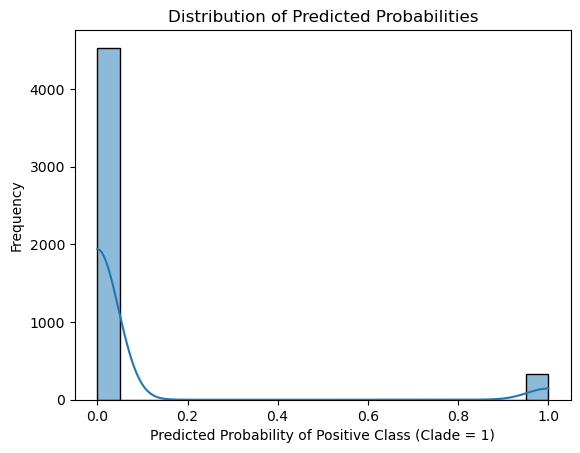

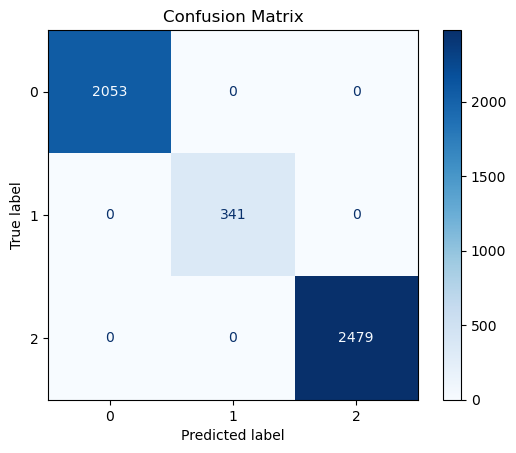

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, ConfusionMatrixDisplay

# Step 1: Get predicted probabilities
y_pred_prob = model.predict_proba(X_test_scaled)[:, 1]  # Probabilities for the positive class (Clade = 1)

# Step 2: Plot the ROC curve
# fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
# roc_auc = auc(fpr, tpr)

# plt.figure()
# plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic (ROC)')
# plt.legend(loc="lower right")
# plt.show()

# Step 3: Plot the predicted probabilities
plt.figure()
sns.histplot(y_pred_prob, bins=20, kde=True)
plt.xlabel('Predicted Probability of Positive Class (Clade = 1)')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Probabilities')
plt.show()

# Step 4: Plot the Confusion Matrix as a heatmap
ConfusionMatrixDisplay.from_estimator(model, X_test_scaled, y_test, cmap='Blues')
plt.title('Confusion Matrix')
plt.show()


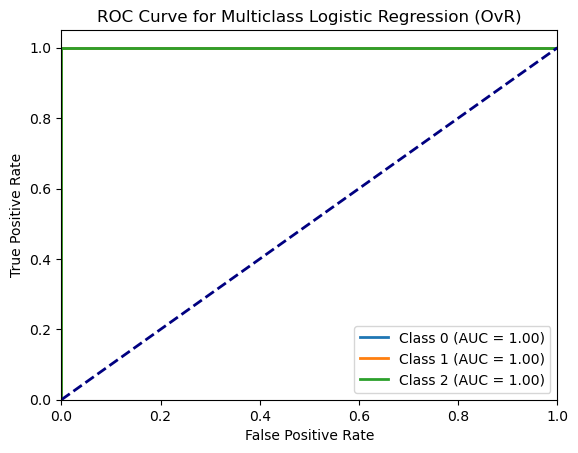

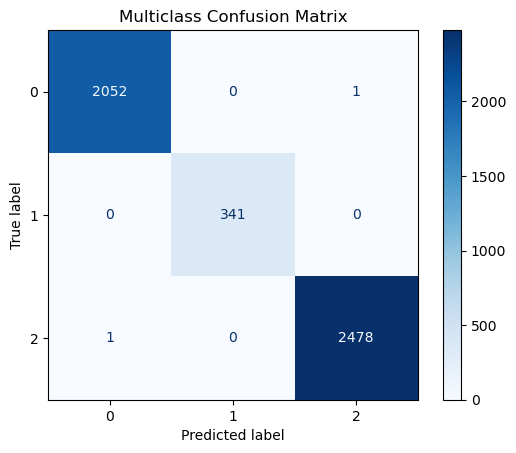

In [19]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
import numpy as np

# Step 1: Binarize the output labels for multiclass ROC curve
n_classes = len(le.classes_)  # Number of unique classes in Clade
y_binarized = label_binarize(y_test, classes=range(n_classes))

# Step 2: Fit the One-vs-Rest Logistic Regression
ovr_classifier = OneVsRestClassifier(LogisticRegression(max_iter=1000))
ovr_classifier.fit(X_train_scaled, y_train)

# Step 3: Predict probabilities for each class
y_pred_prob = ovr_classifier.predict_proba(X_test_scaled)

# Step 4: Plot ROC curves for each class
plt.figure()
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_binarized[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multiclass Logistic Regression (OvR)')
plt.legend(loc="lower right")
plt.show()

# Step 5: Plot the Confusion Matrix for the multiclass case
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(ovr_classifier, X_test_scaled, y_test, cmap='Blues')
plt.title('Multiclass Confusion Matrix')
plt.show()


# version with only nr1/nr4 data

/var/folders/xj/l_c4n_qs0817y_gr39wb6pg80000gn/T/ipykernel_84788/2865926566.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Clade_encoded'] = le.fit_transform(df_filtered['Clade'])


Shape of X: (7764, 1024)
Shape of y: (7764,)
X_train shape: (6211, 1024)
X_test shape: (1553, 1024)
y_train shape: (6211,)
y_test shape: (1553,)
X_train_scaled shape: (6211, 1024)
X_test_scaled shape: (1553, 1024)
Accuracy: 1.0
Confusion Matrix: 
[[1317    0]
 [   0  236]]


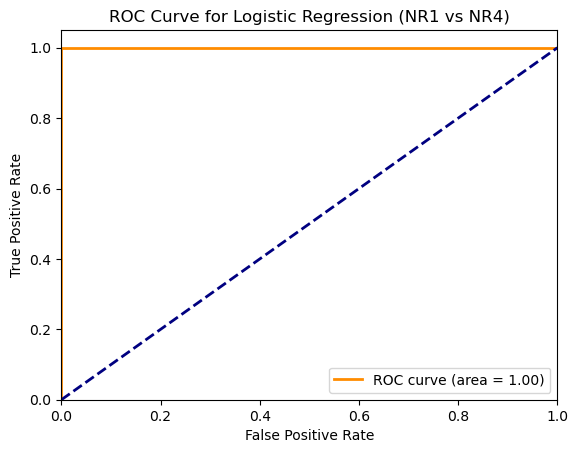

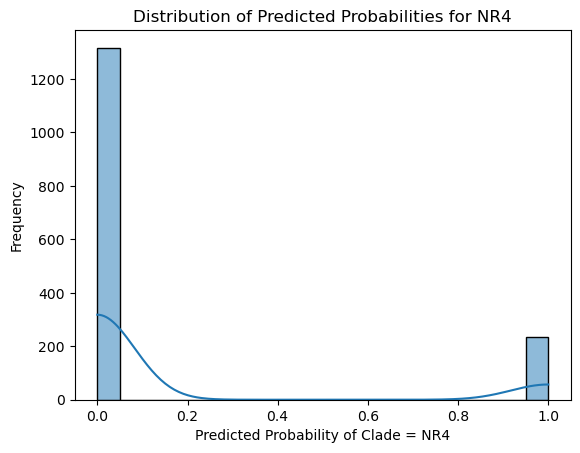

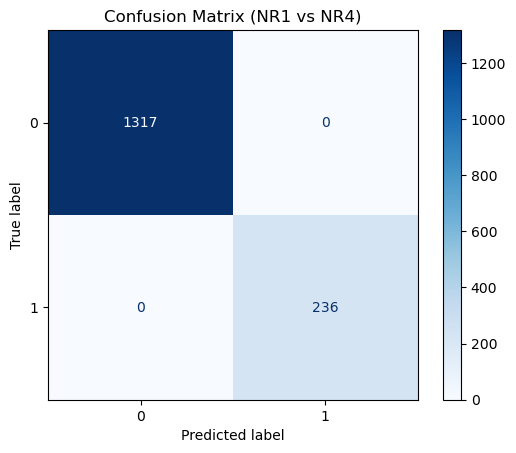

In [22]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Filter the dataframe to keep only Clade = 'NR1' or 'NR4'
df_filtered = df[df['Clade'].isin(['NR1', 'NR4'])]

# Step 2: Encode the Clade column
le = LabelEncoder()
df_filtered['Clade_encoded'] = le.fit_transform(df_filtered['Clade'])

# Step 3: Define features (X) and target (y)
X = df_filtered.drop(columns=['Clade', 'Clade_encoded'])  # Drop non-numerical columns
y = df_filtered['Clade_encoded']

# Check the consistency of X and y before splitting
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

# Step 4: Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the consistency of training and testing sets
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# Step 5: Scale the features (apply scaling only to X, not y)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Check the consistency of scaled data
print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"X_test_scaled shape: {X_test_scaled.shape}")

# Step 6: Train the logistic regression model
# model = LogisticRegression(max_iter=1000)
# model.fit(X_train_scaled, y_train)
model = LogisticRegression(max_iter=1000, class_weight='balanced')
model.fit(X_train_scaled, y_train)

# Step 7: Make predictions and evaluate the model
y_pred = model.predict(X_test_scaled)
y_pred_prob = model.predict_proba(X_test_scaled)[:, 1]  # Probabilities for the positive class (Clade = 'NR4')

# Evaluate accuracy and confusion matrix
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix: \n{conf_matrix}")

# Step 8: Visualizations

# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression (NR1 vs NR4)')
plt.legend(loc="lower right")
plt.show()

# Plot the predicted probabilities
plt.figure()
sns.histplot(y_pred_prob, bins=20, kde=True)
plt.xlabel('Predicted Probability of Clade = NR4')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Probabilities for NR4')
plt.show()

# Plot the Confusion Matrix as a heatmap
ConfusionMatrixDisplay.from_estimator(model, X_test_scaled, y_test, cmap='Blues')
plt.title('Confusion Matrix (NR1 vs NR4)')
plt.show()
